# TP 4 - Entraînement et évaluation du modèle
## Mastère 2 - Data & Intelligence Artificielle

**Durée** : 45 minutes

### Objectifs
1. Charger le dataset nettoyé
2. Séparer en train/test (80/20)
3. Entraîner une Régression Logistique
4. Calculer les métriques (Accuracy, Precision, Recall, F1, AUC)
5. Afficher la matrice de confusion
6. Tracer la courbe ROC
7. Extraire les features les plus importantes
8. (Bonus) Tester Random Forest et comparer

### Critère de réussite
**AUC > 0.70**

## 📦 Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports réussis")

✅ Imports réussis


---
## 📊 ÉTAPE 1 : Chargement des données

In [39]:
print("=" * 80)
print("ÉTAPE 1 : CHARGEMENT DES DONNÉES")
print("=" * 80)

# TODO : Charger le dataset nettoyé
df = pd.read_csv('loan_data_clean.csv')

print(f"\n✅ Dataset chargé : {df.shape[0]} lignes × {df.shape[1]} colonnes")

# 🚨 IMPORTANT : Supprimer Loan_ID si elle existe encore
if 'Loan_ID' in df.columns:
    print("\n⚠️ Colonne 'Loan_ID' détectée dans le dataset nettoyé")
    print("   → Suppression nécessaire : c'est un identifiant sans pouvoir prédictif")
    df = df.drop('Loan_ID', axis=1)
    print(f"   ✅ Loan_ID supprimée - Nouvelles dimensions : {df.shape}")

print(f"\nAperçu :")
df.head()

ÉTAPE 1 : CHARGEMENT DES DONNÉES

✅ Dataset chargé : 614 lignes × 21 colonnes

⚠️ Colonne 'Loan_ID' détectée dans le dataset nettoyé
   → Suppression nécessaire : c'est un identifiant sans pouvoir prédictif
   ✅ Loan_ID supprimée - Nouvelles dimensions : (614, 20)

Aperçu :


,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,LoanAmountToIncome,EMI,EMIToIncome,Log_LoanAmount,Log_TotalIncome,Has_Coapplicant,Area_Semiurban,Area_Urban,Gender_Male,Married_Yes,SelfEmployed_Yes
0,0.0,1,5849.0,0.0,128.0,360.0,1.0,1,5849.0,0.021880,0.355556,0.000061,4.859812,8.674197,0,False,True,True,False,False
1,1.0,1,4583.0,1508.0,128.0,360.0,1.0,0,6091.0,0.021011,0.355556,0.000058,4.859812,8.714732,1,False,False,True,True,False
2,0.0,1,3000.0,0.0,66.0,360.0,1.0,1,3000.0,0.021993,0.183333,0.000061,4.204693,8.006701,0,False,True,True,True,True
3,0.0,0,2583.0,2358.0,120.0,360.0,1.0,1,4941.0,0.024282,0.333333,0.000067,4.795791,8.505525,1,False,True,True,True,False
4,0.0,1,6000.0,0.0,141.0,360.0,1.0,1,6000.0,0.023496,0.391667,0.000065,4.955827,8.699681,0,False,True,True,False,False


In [40]:
# Vérifier qu'il n'y a pas de NaN
if df.isnull().sum().sum() > 0:
    print(f"⚠️ Attention : {df.isnull().sum().sum()} valeurs manquantes détectées")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print("\n✅ Aucune valeur manquante")


✅ Aucune valeur manquante


---
## 🔀 ÉTAPE 2 : Séparation Train/Test

### Pourquoi séparer ?
- **Train set (80%)** : Pour entraîner le modèle
- **Test set (20%)** : Pour évaluer la performance réelle

### Règle d'or
**Ne JAMAIS évaluer sur le train set !**  
Sinon on mesure la **mémorisation**, pas la **généralisation**.

### Stratification
Le paramètre `stratify=y` maintient la proportion de classes dans train et test.

In [41]:
print("\n" + "=" * 80)
print("ÉTAPE 2 : SÉPARATION TRAIN/TEST")
print("=" * 80)

# TODO : Séparer X (features) et y (cible)
# Note : La cible est 'Loan_Status' (1 = Approved, 0 = Rejected)

if 'Loan_Status' not in df.columns:
    raise ValueError("❌ La colonne 'Loan_Status' n'existe pas dans le dataset")

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

print(f"\n✅ Features (X) : {X.shape}")
print(f"✅ Cible (y) : {y.shape}")


ÉTAPE 2 : SÉPARATION TRAIN/TEST

✅ Features (X) : (614, 19)
✅ Cible (y) : (614,)


In [42]:
# 🔍 Vérification : Détecter les colonnes suspectes (identifiants)
print(f"\n🔍 Vérification des colonnes utilisées pour l'entraînement :")
print(f"\nColonnes dans X :")
print(X.columns.tolist())

# Détecter les colonnes avec 'id' dans le nom (potentiels identifiants)
suspicious_cols = [col for col in X.columns if 'id' in col.lower()]
if suspicious_cols:
    print(f"\n⚠️ ATTENTION : Colonnes suspectes détectées : {suspicious_cols}")
    print(f"   → Vérifier si ce sont des identifiants à retirer")
    print(f"   → Les identifiants n'ont pas de pouvoir prédictif et causent du data leakage")
else:
    print(f"\n✅ Aucune colonne suspecte détectée")

# Vérifier qu'il n'y a pas de colonnes avec cardinalité très élevée (potentiels IDs)
high_cardinality_cols = [col for col in X.columns if X[col].nunique() > 0.9 * len(X)]
if high_cardinality_cols:
    print(f"\n⚠️ Colonnes avec cardinalité très élevée (>90% valeurs uniques) :")
    for col in high_cardinality_cols:
        print(f"   • {col}: {X[col].nunique()} valeurs uniques sur {len(X)} lignes")
    print(f"   → Ces colonnes sont probablement des identifiants à retirer")


🔍 Vérification des colonnes utilisées pour l'entraînement :

Colonnes dans X :
['Dependents', 'Education', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'LoanAmountToIncome', 'EMI', 'EMIToIncome', 'Log_LoanAmount', 'Log_TotalIncome', 'Has_Coapplicant', 'Area_Semiurban', 'Area_Urban', 'Gender_Male', 'Married_Yes', 'SelfEmployed_Yes']

✅ Aucune colonne suspecte détectée

⚠️ Colonnes avec cardinalité très élevée (>90% valeurs uniques) :
   • LoanAmountToIncome: 607 valeurs uniques sur 614 lignes
   • EMIToIncome: 610 valeurs uniques sur 614 lignes
   → Ces colonnes sont probablement des identifiants à retirer


In [43]:
# Distribution de la cible
print(f"\nDistribution de la cible :")
print(y.value_counts())
print(f"\nProportions :")
print(y.value_counts(normalize=True) * 100)


Distribution de la cible :
Loan_Status
1    422
0    192
Name: count, dtype: int64

Proportions :
Loan_Status
1    68.729642
0    31.270358
Name: proportion, dtype: float64


In [44]:
# TODO : Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,           # 20% pour le test
    random_state=42,         # Reproductibilité
    stratify=y               # Maintient les proportions de classes
)

# stocker X_test et y_test dans un fichier csv pour une utilisation ultérieure
# Path de base fourni
base_dir = r"D:\Users\glenn\Downloads\M2 Nexa\applications web pour visualiser des données\tp"

# Construire les chemins complets
path_X = os.path.join(base_dir, "X_test.csv")
path_y = os.path.join(base_dir, "y_test.csv")

# Sauvegarder les fichiers
X_test.to_csv(path_X, index=False)
y_test.to_csv(path_y, index=False)

print("Fichiers enregistrés :")
print(path_X)
print(path_y)


print(f"\n✅ Train set : {X_train.shape[0]} observations ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"✅ Test set : {X_test.shape[0]} observations ({X_test.shape[0]/len(df)*100:.1f}%)")

Fichiers enregistrés :
D:\Users\glenn\Downloads\M2 Nexa\applications web pour visualiser des données\tp\X_test.csv
D:\Users\glenn\Downloads\M2 Nexa\applications web pour visualiser des données\tp\y_test.csv

✅ Train set : 491 observations (80.0%)
✅ Test set : 123 observations (20.0%)


In [45]:
# Vérifier la stratification
print(f"\nDistribution train :")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nDistribution test :")
print(y_test.value_counts(normalize=True) * 100)
print("\n✅ Les proportions sont identiques (stratification réussie)")


Distribution train :
Loan_Status
1    68.635438
0    31.364562
Name: proportion, dtype: float64

Distribution test :
Loan_Status
1    69.105691
0    30.894309
Name: proportion, dtype: float64

✅ Les proportions sont identiques (stratification réussie)


---
## 📏 ÉTAPE 3 : Normalisation des données

### Pourquoi normaliser ?
La **Régression Logistique** est sensible à l'échelle des variables :
- Si une variable est en milliers d'euros (revenu : 5000)
- Et une autre en années (durée prêt : 30)
- Le modèle donnera trop d'importance à la première

### StandardScaler
Transforme chaque variable pour avoir :
- **Moyenne = 0**
- **Écart-type = 1**

### ⚠️ IMPORTANT
- `fit_transform` sur **train** : apprend les paramètres (moyenne, std)
- `transform` seulement sur **test** : applique les paramètres appris
- **Sinon** : data leakage (fuite d'information du test vers le train)

In [46]:
print("\n" + "=" * 80)
print("ÉTAPE 3 : NORMALISATION (StandardScaler)")
print("=" * 80)

# TODO : Normaliser avec StandardScaler
scaler = StandardScaler()

# ⚠️ IMPORTANT : fit_transform sur train, transform seulement sur test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Normalisation effectuée")
print(f"   Moyenne train (avant) : {X_train.mean().mean():.3f}")
print(f"   Moyenne train (après) : {X_train_scaled.mean():.3f}")
print(f"   Écart-type train (avant) : {X_train.std().mean():.3f}")
print(f"   Écart-type train (après) : {X_train_scaled.std():.3f}")


ÉTAPE 3 : NORMALISATION (StandardScaler)

✅ Normalisation effectuée
   Moyenne train (avant) : 737.637
   Moyenne train (après) : -0.000
   Écart-type train (avant) : 593.933
   Écart-type train (après) : 1.000


---
## 🤖 ÉTAPE 4 : Entraînement - Régression Logistique

### Pourquoi la Régression Logistique ?
✅ **Simple** : Facile à comprendre et interpréter  
✅ **Rapide** : Entraînement très rapide  
✅ **Baseline solide** : Bon point de départ  
✅ **Explicable** : Coefficients = importance des variables  
✅ **Conforme Ethics by Design** : Transparence  

### Comment ça marche ?
La régression logistique calcule la probabilité qu'un prêt soit approuvé :
- Combine les features avec des **coefficients** (poids)
- Passe par une fonction **sigmoïde** pour obtenir une probabilité [0, 1]
- Si probabilité > 0.5 → Approuvé, sinon → Rejeté

In [47]:
print("\n" + "=" * 80)
print("ÉTAPE 4 : ENTRAÎNEMENT - RÉGRESSION LOGISTIQUE")
print("=" * 80)

# TODO : Créer et entraîner le modèle
model_lr = LogisticRegression(
    random_state=42,
    max_iter=1000,           # Augmenter si le modèle ne converge pas
    solver='lbfgs'           # Solver par défaut, efficace
)

print("\n🚀 Entraînement en cours...")
model_lr.fit(X_train_scaled, y_train)
print("✅ Modèle entraîné avec succès !")


ÉTAPE 4 : ENTRAÎNEMENT - RÉGRESSION LOGISTIQUE

🚀 Entraînement en cours...
✅ Modèle entraîné avec succès !


---
## 🎯 ÉTAPE 5 : Prédictions

In [48]:
print("\n" + "=" * 80)
print("ÉTAPE 5 : PRÉDICTIONS")
print("=" * 80)

# TODO : Faire des prédictions sur le test set
y_pred_lr = model_lr.predict(X_test_scaled)
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]  # Probabilité de la classe 1

print(f"\n✅ Prédictions effectuées sur {len(y_pred_lr)} observations")


ÉTAPE 5 : PRÉDICTIONS

✅ Prédictions effectuées sur 123 observations


In [49]:
# Afficher quelques prédictions
print(f"\nPremières prédictions :")
predictions_df = pd.DataFrame({
    'Vrai': y_test.values[:10],
    'Prédit': y_pred_lr[:10],
    'Proba': y_pred_proba_lr[:10]
})
predictions_df['Correct'] = predictions_df['Vrai'] == predictions_df['Prédit']
predictions_df


Premières prédictions :


,Vrai,Prédit,Proba,Correct
0,0,0,0.048072,True
1,1,1,0.915163,True
2,1,1,0.687691,True
3,1,1,0.839049,True
4,1,1,0.905057,True
5,0,1,0.837827,False
6,1,1,0.837935,True
7,1,1,0.888122,True
8,1,1,0.656266,True
9,1,1,0.800601,True


---
## 📊 ÉTAPE 6 : Métriques d'évaluation

### Les métriques clés

#### 1. Accuracy (Exactitude)
$$\text{Accuracy} = \frac{\text{Prédictions correctes}}{\text{Total}}$$
- Simple mais trompeuse si classes déséquilibrées

#### 2. Precision (Précision)
$$\text{Precision} = \frac{TP}{TP + FP}$$
- "Parmi les prêts approuvés par le modèle, combien sont vraiment solvables ?"

#### 3. Recall (Rappel)
$$\text{Recall} = \frac{TP}{TP + FN}$$
- "Parmi les prêts vraiment solvables, combien le modèle a-t-il détectés ?"

#### 4. F1-Score
$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
- Moyenne harmonique de Precision et Recall

#### 5. AUC (Area Under Curve)
- Mesure globale de performance
- 0.5 = modèle aléatoire, 1.0 = modèle parfait
- **> 0.7** = bon, **> 0.8** = très bon, **> 0.9** = excellent

In [50]:
print("\n" + "=" * 80)
print("ÉTAPE 6 : MÉTRIQUES D'ÉVALUATION")
print("=" * 80)

# TODO : Calculer les métriques
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"""
📊 MÉTRIQUES DE PERFORMANCE
{"=" * 50}
Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)
Precision : {precision:.4f} ({precision*100:.2f}%)
Recall    : {recall:.4f} ({recall*100:.2f}%)
F1-Score  : {f1:.4f}
AUC       : {auc:.4f}
{"=" * 50}
""")


ÉTAPE 6 : MÉTRIQUES D'ÉVALUATION

📊 MÉTRIQUES DE PERFORMANCE
Accuracy  : 0.8537 (85.37%)
Precision : 0.8317 (83.17%)
Recall    : 0.9882 (98.82%)
F1-Score  : 0.9032
AUC       : 0.8632



In [51]:
# Interprétation des métriques
print("💡 INTERPRÉTATION :")
print(f"   • Accuracy : {accuracy*100:.1f}% des prédictions sont correctes")
print(f"   • Precision : Parmi les prêts approuvés par le modèle, {precision*100:.1f}% sont vraiment solvables")
print(f"   • Recall : Parmi les prêts vraiment solvables, {recall*100:.1f}% sont détectés par le modèle")
print(f"   • F1-Score : Équilibre entre Precision et Recall")
print(f"   • AUC : {auc:.3f} → ", end="")
if auc >= 0.9:
    print("Excellent modèle ! 🌟")
elif auc >= 0.8:
    print("Très bon modèle 👍")
elif auc >= 0.7:
    print("Bon modèle ✅")
else:
    print("Modèle à améliorer ⚠️")

💡 INTERPRÉTATION :
   • Accuracy : 85.4% des prédictions sont correctes
   • Precision : Parmi les prêts approuvés par le modèle, 83.2% sont vraiment solvables
   • Recall : Parmi les prêts vraiment solvables, 98.8% sont détectés par le modèle
   • F1-Score : Équilibre entre Precision et Recall
   • AUC : 0.863 → Très bon modèle 👍


In [52]:
# Classification report détaillé
print(f"\n📋 RAPPORT DE CLASSIFICATION :\n")
print(classification_report(y_test, y_pred_lr, 
                          target_names=['Rejected (0)', 'Approved (1)']))


📋 RAPPORT DE CLASSIFICATION :

              precision    recall  f1-score   support

Rejected (0)       0.95      0.55      0.70        38
Approved (1)       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



---
## 🎲 ÉTAPE 7 : Matrice de confusion

### Qu'est-ce que c'est ?
Un tableau qui montre les **4 types de prédictions** :

|                | Prédit Rejected | Prédit Approved |
|----------------|-----------------|------------------|
| **Vraiment Rejected** | TN (True Negative) | FP (False Positive) |
| **Vraiment Approved** | FN (False Negative) | TP (True Positive) |

- **TN** : Correctement rejeté ✅
- **FP** : Faussement approuvé ❌ (Risque pour la banque)
- **FN** : Faussement rejeté ❌ (Client perdu)
- **TP** : Correctement approuvé ✅

### Question éthique
Quelle erreur est la plus grave ?
- **FP** : Approuver quelqu'un qui va faire défaut → Perte d'argent
- **FN** : Rejeter quelqu'un de solvable → Discrimination potentielle


ÉTAPE 7 : MATRICE DE CONFUSION
✅ Matrice de confusion sauvegardée : 'confusion_matrix.png'


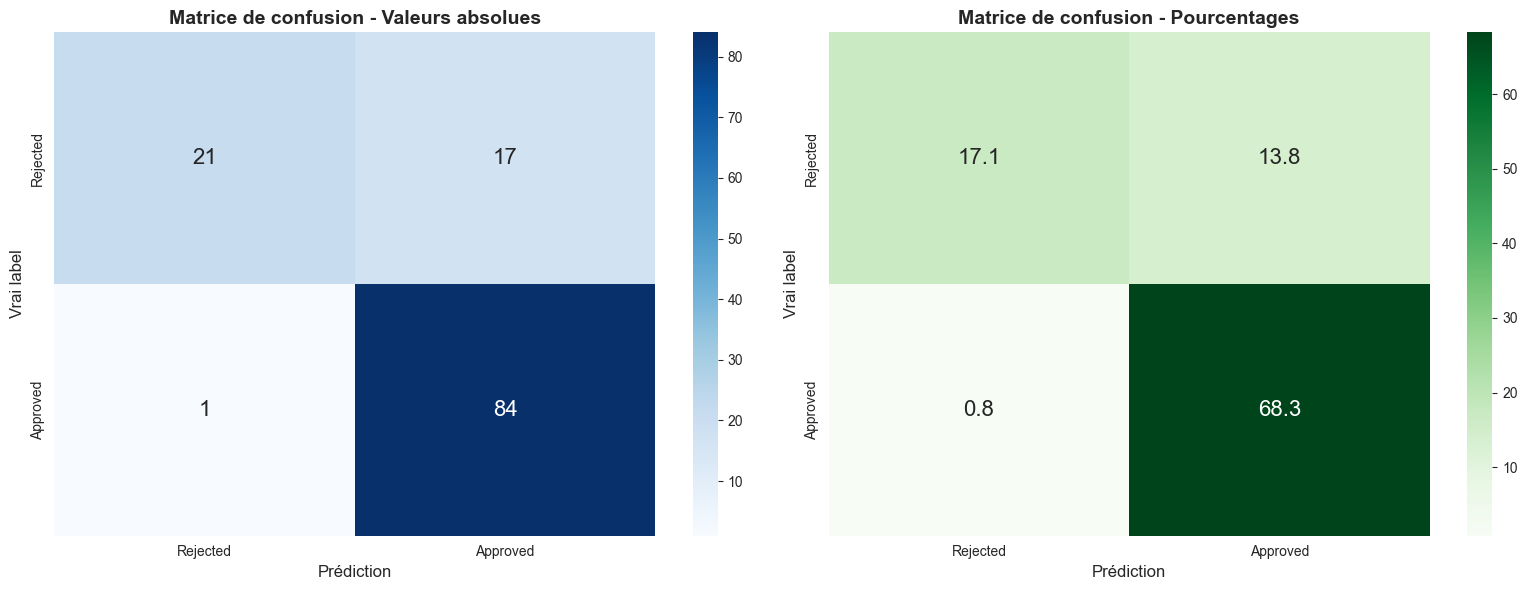

In [53]:
print("\n" + "=" * 80)
print("ÉTAPE 7 : MATRICE DE CONFUSION")
print("=" * 80)

# TODO : Calculer et afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_lr)

# Créer une figure avec deux visualisations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matrice de confusion - Nombres absolus
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'],
            ax=axes[0], annot_kws={'size': 16})
axes[0].set_title('Matrice de confusion - Valeurs absolues', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Vrai label', fontsize=12)
axes[0].set_xlabel('Prédiction', fontsize=12)

# Matrice de confusion - Pourcentages
cm_percent = cm / cm.sum() * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens', cbar=True,
            xticklabels=['Rejected', 'Approved'],
            yticklabels=['Rejected', 'Approved'],
            ax=axes[1], annot_kws={'size': 16})
axes[1].set_title('Matrice de confusion - Pourcentages', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Vrai label', fontsize=12)
axes[1].set_xlabel('Prédiction', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Matrice de confusion sauvegardée : 'confusion_matrix.png'")
plt.show()

In [54]:
# Analyser les erreurs
TN, FP, FN, TP = cm.ravel()
print(f"""
📊 ANALYSE DE LA MATRICE :
{"=" * 50}
True Negatives (TN)  : {TN:3d} - Bien rejetés ✅
False Positives (FP) : {FP:3d} - Faussement approuvés ⚠️ (Risque pour la banque)
False Negatives (FN) : {FN:3d} - Faussement rejetés ⚠️ (Clients perdus)
True Positives (TP)  : {TP:3d} - Bien approuvés ✅
{"=" * 50}
Total erreurs        : {FP + FN:3d} ({(FP + FN) / len(y_test) * 100:.1f}%)
""")


📊 ANALYSE DE LA MATRICE :
True Negatives (TN)  :  21 - Bien rejetés ✅
False Positives (FP) :  17 - Faussement approuvés ⚠️ (Risque pour la banque)
False Negatives (FN) :   1 - Faussement rejetés ⚠️ (Clients perdus)
True Positives (TP)  :  84 - Bien approuvés ✅
Total erreurs        :  18 (14.6%)



---
## 📈 ÉTAPE 8 : Courbe ROC

### Qu'est-ce que la courbe ROC ?
**ROC** = Receiver Operating Characteristic
- Montre le trade-off entre **True Positive Rate** (Recall) et **False Positive Rate**
- Pour différents **seuils de décision** (par défaut 0.5)

### Comment lire la courbe ?
- **Ligne diagonale** : Modèle aléatoire (AUC = 0.5)
- **Plus la courbe est haute** : Meilleur est le modèle
- **AUC** : Résume la courbe en un nombre [0, 1]

### Pourquoi c'est important ?
- Mesure la performance **indépendamment du seuil**
- Robuste au **déséquilibre de classes**
- Métrique favorite en ML


ÉTAPE 8 : COURBE ROC

✅ Courbe ROC sauvegardée : 'roc_curve.png'


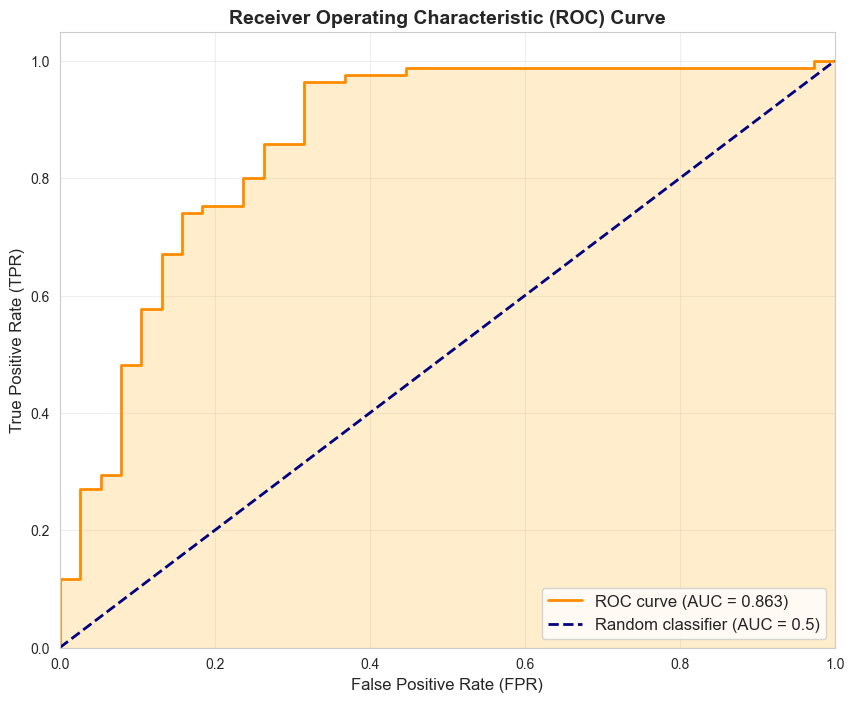

In [55]:
print("\n" + "=" * 80)
print("ÉTAPE 8 : COURBE ROC")
print("=" * 80)

# TODO : Calculer et tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier (AUC = 0.5)')
plt.fill_between(fpr, tpr, alpha=0.2, color='orange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
print("\n✅ Courbe ROC sauvegardée : 'roc_curve.png'")
plt.show()

In [56]:
print(f"\n💡 INTERPRÉTATION DE LA COURBE ROC :")
print(f"   • Plus la courbe s'éloigne de la diagonale, meilleur est le modèle")
print(f"   • AUC = {auc:.3f} → Surface sous la courbe")
print(f"   • Un modèle parfait aurait AUC = 1.0")
print(f"   • Un modèle aléatoire a AUC = 0.5")


💡 INTERPRÉTATION DE LA COURBE ROC :
   • Plus la courbe s'éloigne de la diagonale, meilleur est le modèle
   • AUC = 0.863 → Surface sous la courbe
   • Un modèle parfait aurait AUC = 1.0
   • Un modèle aléatoire a AUC = 0.5


---
## 🔍 ÉTAPE 9 : Feature Importance

### Pourquoi c'est crucial ?
✅ **Explicabilité** : Comprendre quelles variables influencent les décisions  
✅ **Ethics by Design** : Transparence des algorithmes  
✅ **Débogage** : Identifier les variables problématiques  
✅ **Insights métier** : Découvrir des patterns intéressants  

### Comment l'interpréter ?
Pour la Régression Logistique, les **coefficients** indiquent :
- **Positif** : Augmente la probabilité d'approbation
- **Négatif** : Diminue la probabilité d'approbation
- **Grande valeur absolue** : Impact fort

In [57]:
print("\n" + "=" * 80)
print("ÉTAPE 9 : FEATURE IMPORTANCE")
print("=" * 80)

# TODO : Extraire les coefficients du modèle
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_lr.coef_[0],
    'Abs_Coefficient': np.abs(model_lr.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n📊 TOP 10 FEATURES LES PLUS IMPORTANTES :\n")
print(feature_importance.head(10).to_string(index=False))


ÉTAPE 9 : FEATURE IMPORTANCE

📊 TOP 10 FEATURES LES PLUS IMPORTANTES :

          Feature  Coefficient  Abs_Coefficient
   Credit_History     1.284650         1.284650
      EMIToIncome    -0.837333         0.837333
       LoanAmount    -0.711500         0.711500
              EMI     0.627924         0.627924
   Log_LoanAmount     0.548797         0.548797
  Has_Coapplicant     0.433239         0.433239
   Area_Semiurban     0.411703         0.411703
CoapplicantIncome    -0.336512         0.336512
        Education     0.202480         0.202480
 Loan_Amount_Term    -0.163159         0.163159



✅ Feature importance sauvegardée : 'feature_importance.png'


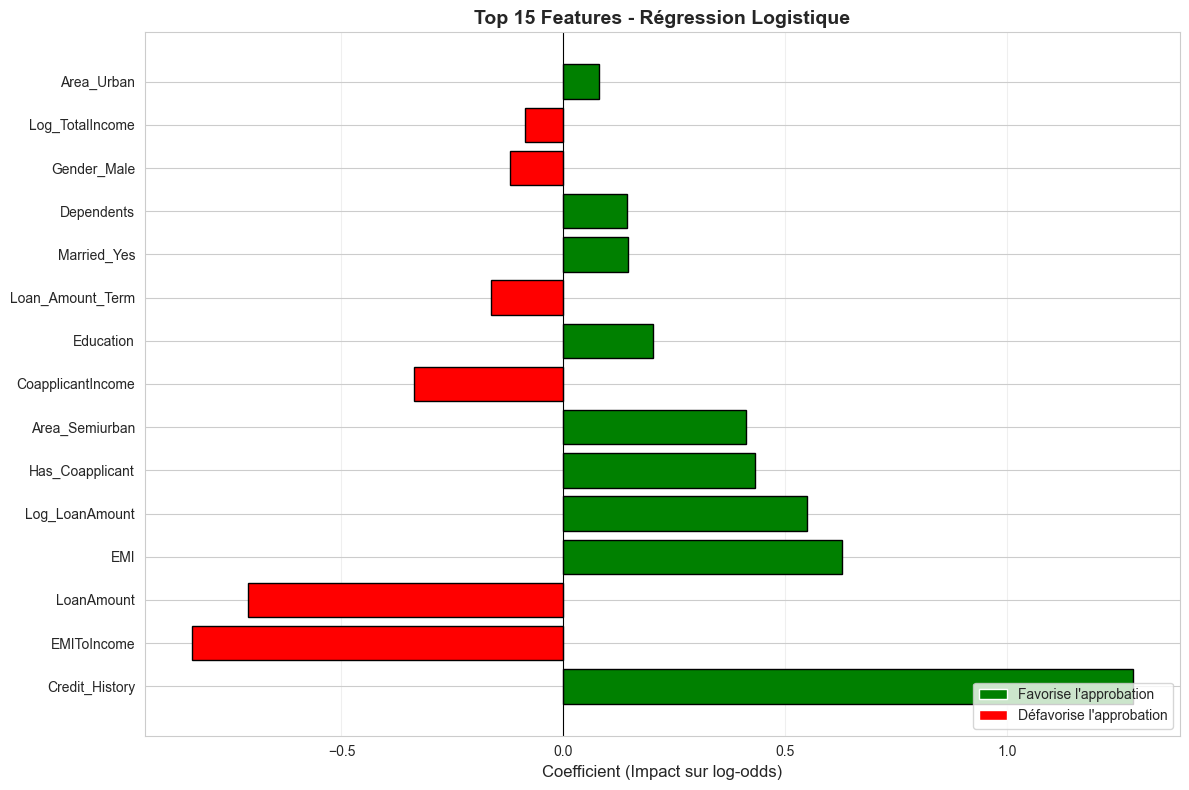

In [58]:
# Visualisation
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient (Impact sur log-odds)', fontsize=12)
plt.title('Top 15 Features - Régression Logistique', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)

# Ajouter une légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Favorise l\'approbation'),
                   Patch(facecolor='red', label='Défavorise l\'approbation')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Feature importance sauvegardée : 'feature_importance.png'")
plt.show()

In [59]:
print(f"\n💡 INTERPRÉTATION :")
print(f"   • Coefficient positif (vert) → Augmente la probabilité d'approbation")
print(f"   • Coefficient négatif (rouge) → Diminue la probabilité d'approbation")
print(f"   • Plus le coefficient est grand (en valeur absolue), plus la feature est importante")


💡 INTERPRÉTATION :
   • Coefficient positif (vert) → Augmente la probabilité d'approbation
   • Coefficient négatif (rouge) → Diminue la probabilité d'approbation
   • Plus le coefficient est grand (en valeur absolue), plus la feature est importante


---
## ✅ ÉTAPE 10 : Validation croisée

### Pourquoi la validation croisée ?
Un seul split train/test peut être **chanceux** ou **malchanceux**.

### K-Fold Cross-Validation (K=5)
1. Diviser le train set en **5 parties**
2. Entraîner **5 modèles** différents :
   - Modèle 1 : Entraîne sur folds 1-4, valide sur fold 5
   - Modèle 2 : Entraîne sur folds 1-3+5, valide sur fold 4
   - ...
3. Moyenner les **5 scores**

### Avantage
Estimation plus **robuste** de la performance réelle.

In [60]:
print("\n" + "=" * 80)
print("ÉTAPE 10 : VALIDATION CROISÉE (5-FOLD)")
print("=" * 80)

# TODO : Effectuer une validation croisée
cv_scores = cross_val_score(model_lr, X_train_scaled, y_train, cv=5, scoring='roc_auc')

print(f"\n📊 SCORES DE VALIDATION CROISÉE :")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i} : {score:.4f}")
print(f"   {'─' * 30}")
print(f"   Moyenne : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n💡 La validation croisée confirme que le modèle est {'robuste' if cv_scores.std() < 0.05 else 'variable'}")
print(f"   (Écart-type faible = modèle stable)")


ÉTAPE 10 : VALIDATION CROISÉE (5-FOLD)

📊 SCORES DE VALIDATION CROISÉE :
   Fold 1 : 0.7500
   Fold 2 : 0.7387
   Fold 3 : 0.8512
   Fold 4 : 0.6967
   Fold 5 : 0.6856
   ──────────────────────────────
   Moyenne : 0.7444 ± 0.0587

💡 La validation croisée confirme que le modèle est variable
   (Écart-type faible = modèle stable)


---
## 🎁 BONUS : Random Forest

### Pourquoi tester Random Forest ?
✅ **Plus puissant** : Capture les non-linéarités  
✅ **Robuste** : Résistant aux outliers  
✅ **Feature importance native** : Facile à interpréter  

### Inconvénients
❌ **Moins explicable** : Boîte noire (vs régression logistique)  
❌ **Plus lent** : Entraînement plus long  

### Note
Random Forest ne nécessite **pas de normalisation** (contrairement à la régression logistique).

In [61]:
print("\n" + "=" * 80)
print("BONUS : RANDOM FOREST")
print("=" * 80)

# TODO : Entraîner un Random Forest pour comparaison
model_rf = RandomForestClassifier(
    n_estimators=100,        # Nombre d'arbres
    max_depth=10,            # Profondeur max
    random_state=42,
    class_weight='balanced',  # Compense le déséquilibre
    n_jobs=-1                # Utiliser tous les CPU
)

print("\n🚀 Entraînement Random Forest en cours...")
model_rf.fit(X_train, y_train)  # Pas besoin de normalisation pour RF
print("✅ Random Forest entraîné")


BONUS : RANDOM FOREST

🚀 Entraînement Random Forest en cours...
✅ Random Forest entraîné


In [62]:
# Prédictions
y_pred_rf = model_rf.predict(X_test)
y_pred_proba_rf = model_rf.predict_proba(X_test)[:, 1]

# Métriques
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print(f"""
📊 MÉTRIQUES RANDOM FOREST
{"=" * 50}
Accuracy  : {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)
Precision : {precision_rf:.4f} ({precision_rf*100:.2f}%)
Recall    : {recall_rf:.4f} ({recall_rf*100:.2f}%)
F1-Score  : {f1_rf:.4f}
AUC       : {auc_rf:.4f}
{"=" * 50}
""")


📊 MÉTRIQUES RANDOM FOREST
Accuracy  : 0.8537 (85.37%)
Precision : 0.8602 (86.02%)
Recall    : 0.9412 (94.12%)
F1-Score  : 0.8989
AUC       : 0.8545



---
## 📊 ÉTAPE 12 : Comparaison des modèles

In [63]:
print("\n" + "=" * 80)
print("COMPARAISON RÉGRESSION LOGISTIQUE vs RANDOM FOREST")
print("=" * 80)

# Tableau comparatif
comparison = pd.DataFrame({
    'Métrique': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
    'Régression Logistique': [accuracy, precision, recall, f1, auc],
    'Random Forest': [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]
})

print("\n📊 TABLEAU COMPARATIF :\n")
print(comparison.to_string(index=False))


COMPARAISON RÉGRESSION LOGISTIQUE vs RANDOM FOREST

📊 TABLEAU COMPARATIF :

 Métrique  Régression Logistique  Random Forest
 Accuracy               0.853659       0.853659
Precision               0.831683       0.860215
   Recall               0.988235       0.941176
 F1-Score               0.903226       0.898876
      AUC               0.863158       0.854489



✅ Comparaison sauvegardée : 'model_comparison.png'


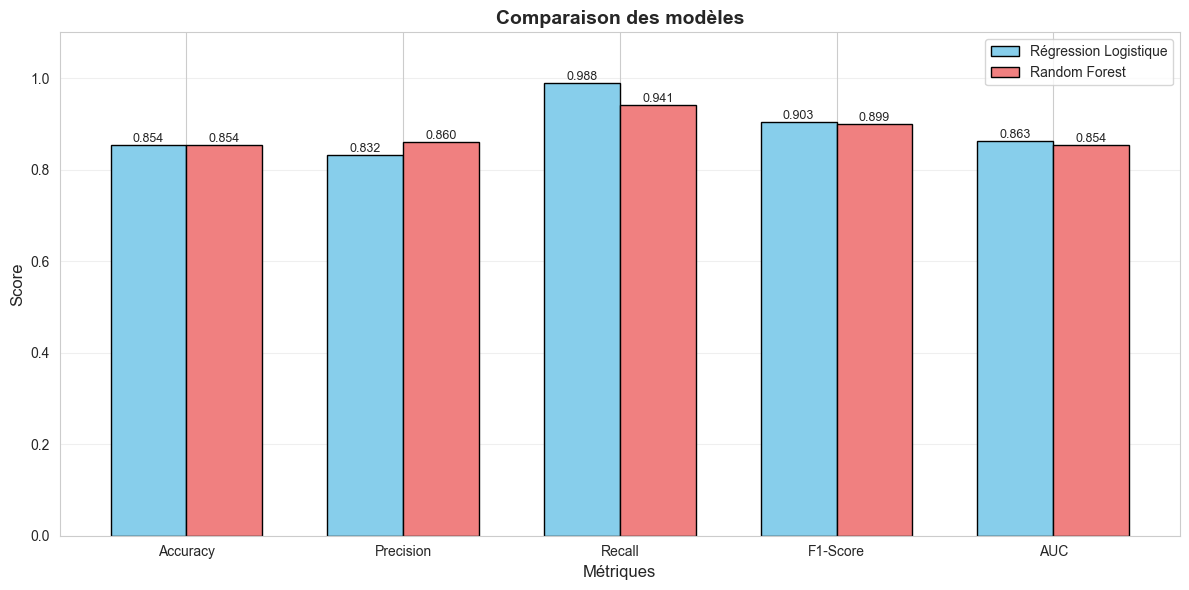

In [64]:
# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison['Métrique']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison['Régression Logistique'], width, 
               label='Régression Logistique', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, comparison['Random Forest'], width,
               label='Random Forest', color='lightcoral', edgecolor='black')

ax.set_xlabel('Métriques', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Comparaison des modèles', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Métrique'])
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✅ Comparaison sauvegardée : 'model_comparison.png'")
plt.show()

In [65]:
# Recommandation
print(f"\n🎯 RECOMMANDATION :")
if auc_rf > auc + 0.05:
    print(f"   → Random Forest est significativement meilleur (AUC +{auc_rf - auc:.3f})")
    print(f"   → Considérer Random Forest pour le projet final")
elif auc > auc_rf + 0.05:
    print(f"   → Régression Logistique est meilleure (AUC +{auc - auc_rf:.3f})")
    print(f"   → Garder Régression Logistique (plus interprétable)")
else:
    print(f"   → Les deux modèles sont équivalents (différence : {abs(auc - auc_rf):.3f})")
    print(f"   → Privilégier Régression Logistique pour l'explicabilité (Ethics by Design)")


🎯 RECOMMANDATION :
   → Les deux modèles sont équivalents (différence : 0.009)
   → Privilégier Régression Logistique pour l'explicabilité (Ethics by Design)


---
## 💾 ÉTAPE 13 : Sauvegarde des modèles et du scaler

### Pourquoi sauvegarder ?
Pour **réutiliser** les modèles sans les réentraîner :
- ✅ **Jour 2** : Intégration dans l'application Streamlit
- ✅ **Production** : Déploiement de l'application
- ✅ **Partage** : Collaboration avec d'autres développeurs
- ✅ **Reproductibilité** : Garantir les mêmes prédictions

### Formats de sauvegarde

#### 1. Joblib (recommandé pour scikit-learn)
- Plus efficace que pickle pour les gros modèles
- Compression intégrée
- Format standard pour scikit-learn

#### 2. Pickle (alternative)
- Format Python universel
- Moins optimisé pour ML

### ⚠️ IMPORTANT
Il faut sauvegarder **AUSSI le scaler** !
- En production, les nouvelles données doivent être normalisées avec les **mêmes paramètres** (moyenne, std) que le train set
- Sans le scaler, les prédictions seront fausses

In [66]:
import joblib
import os

print("\n" + "=" * 80)
print("ÉTAPE 13 : SAUVEGARDE DES MODÈLES ET DU SCALER")
print("=" * 80)

# Créer un dossier 'models' s'il n'existe pas
os.makedirs('models', exist_ok=True)
print("\n✅ Dossier 'models/' créé (ou déjà existant)")


ÉTAPE 13 : SAUVEGARDE DES MODÈLES ET DU SCALER

✅ Dossier 'models/' créé (ou déjà existant)


### Sauvegarde du scaler

In [67]:
# TODO : Sauvegarder le scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)

# Vérifier la taille du fichier
scaler_size = os.path.getsize(scaler_path) / 1024  # En Ko
print(f"\n✅ Scaler sauvegardé : {scaler_path} ({scaler_size:.2f} Ko)")


✅ Scaler sauvegardé : models/scaler.pkl (1.53 Ko)


### Sauvegarde de la Régression Logistique

In [68]:
# TODO : Sauvegarder le modèle de régression logistique
lr_model_path = 'models/logistic_regression.pkl'
joblib.dump(model_lr, lr_model_path)

# Vérifier la taille
lr_size = os.path.getsize(lr_model_path) / 1024
print(f"\n✅ Régression Logistique sauvegardée : {lr_model_path} ({lr_size:.2f} Ko)")


✅ Régression Logistique sauvegardée : models/logistic_regression.pkl (1.00 Ko)


### Sauvegarde du Random Forest

In [69]:
# TODO : Sauvegarder le modèle Random Forest
rf_model_path = 'models/random_forest.pkl'
joblib.dump(model_rf, rf_model_path, compress=3)  # Compression niveau 3

# Vérifier la taille
rf_size = os.path.getsize(rf_model_path) / 1024
print(f"\n✅ Random Forest sauvegardé : {rf_model_path} ({rf_size:.2f} Ko)")
print(f"   (avec compression niveau 3)")


✅ Random Forest sauvegardé : models/random_forest.pkl (307.92 Ko)
   (avec compression niveau 3)


### Sauvegarde des métadonnées

In [70]:
# TODO : Sauvegarder les métadonnées importantes\n
import json
from datetime import datetime

metadata = {
    'date_creation': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns),
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'models': {
        'logistic_regression': {
            'accuracy': float(accuracy),
            'precision': float(precision),
            'recall': float(recall),
            'f1_score': float(f1),
            'auc': float(auc),
            'file': lr_model_path
        },
        'random_forest': {
            'accuracy': float(accuracy_rf),
            'precision': float(precision_rf),
            'recall': float(recall_rf),
            'f1_score': float(f1_rf),
            'auc': float(auc_rf),
            'file': rf_model_path,
            'n_estimators': model_rf.n_estimators,
            'max_depth': model_rf.max_depth
        }
    },
    'scaler': {
        'type': 'StandardScaler',
        'file': scaler_path
    }
}

# Sauvegarder en JSON
metadata_path = 'models/metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)
    
print(f"✅ Métadonnées sauvegardées : {metadata_path}")

✅ Métadonnées sauvegardées : models/metadata.json


### Test de chargement (vérification)

In [71]:
print("\n" + "─" * 80)
print("🔍 TEST DE CHARGEMENT (vérification que les fichiers sont OK)")
print("─" * 80)

# Charger le scaler
try:
    loaded_scaler = joblib.load(scaler_path)
    print("\n✅ Scaler chargé avec succès")
except Exception as e:
    print(f"\n❌ Erreur lors du chargement du scaler : {e}")

# Charger la régression logistique
try:
    loaded_lr = joblib.load(lr_model_path)
    print("✅ Régression Logistique chargée avec succès")
except Exception as e:
    print(f"❌ Erreur lors du chargement de la Régression Logistique : {e}")

# Charger le Random Forest
try:
    loaded_rf = joblib.load(rf_model_path)
    print("✅ Random Forest chargé avec succès")
except Exception as e:
    print(f"❌ Erreur lors du chargement du Random Forest : {e}")

# Charger les métadonnées
try:
    with open(metadata_path, 'r') as f:
        loaded_metadata = json.load(f)
    print("✅ Métadonnées chargées avec succès")
except Exception as e:
    print(f"❌ Erreur lors du chargement des métadonnées : {e}")


────────────────────────────────────────────────────────────────────────────────
🔍 TEST DE CHARGEMENT (vérification que les fichiers sont OK)
────────────────────────────────────────────────────────────────────────────────

✅ Scaler chargé avec succès
✅ Régression Logistique chargée avec succès
✅ Random Forest chargé avec succès
✅ Métadonnées chargées avec succès


### Test de prédiction avec les modèles chargés

In [72]:
print("\n" + "─" * 80)
print("🧪 TEST DE PRÉDICTION avec les modèles chargés")
print("─" * 80)

# Prendre un échantillon du test set
sample_X = X_test.iloc[0:1]
print(f"\nÉchantillon de test :")
print(sample_X)

# Prédiction avec le modèle chargé (Régression Logistique)
sample_X_scaled = loaded_scaler.transform(sample_X)
pred_loaded = loaded_lr.predict(sample_X_scaled)
proba_loaded = loaded_lr.predict_proba(sample_X_scaled)[:, 1]

print(f"\n✅ Prédiction (modèle chargé) : {'Approved' if pred_loaded[0] == 1 else 'Rejected'}")
print(f"   Probabilité d'approbation : {proba_loaded[0]:.2%}")

# Vérifier que c'est identique au modèle original
pred_original = model_lr.predict(scaler.transform(sample_X))
if pred_loaded[0] == pred_original[0]:
    print("\n✅ Les prédictions du modèle chargé et original sont identiques")
    print("   → Sauvegarde/chargement réussis !")
else:
    print("\n⚠️ ATTENTION : Les prédictions diffèrent !")
    print("   → Problème de sauvegarde/chargement")


────────────────────────────────────────────────────────────────────────────────
🧪 TEST DE PRÉDICTION avec les modèles chargés
────────────────────────────────────────────────────────────────────────────────

Échantillon de test :
     Dependents  Education  ApplicantIncome  CoapplicantIncome  LoanAmount  \
150         0.0          1           6277.0                0.0       118.0   

     Loan_Amount_Term  Credit_History  TotalIncome  LoanAmountToIncome  \
150             360.0             0.0       6277.0            0.018796   

          EMI  EMIToIncome  Log_LoanAmount  Log_TotalIncome  Has_Coapplicant  \
150  0.327778     0.000052        4.779123         8.744807                0   

     Area_Semiurban  Area_Urban  Gender_Male  Married_Yes  SelfEmployed_Yes  
150           False       False         True        False             False  

✅ Prédiction (modèle chargé) : Rejected
   Probabilité d'approbation : 4.81%

✅ Les prédictions du modèle chargé et original sont identiques
   

### Récapitulatif des fichiers sauvegardés

In [73]:
print("\n" + "=" * 80)
print("📦 FICHIERS SAUVEGARDÉS DANS models/")
print("=" * 80)

files_info = []
for filename in os.listdir('models'):
    filepath = os.path.join('models', filename)
    size = os.path.getsize(filepath) / 1024  # Ko
    files_info.append({'Fichier': filename, 'Taille (Ko)': f"{size:.2f}"})

files_df = pd.DataFrame(files_info)
print("\n" + files_df.to_string(index=False))

total_size = sum([os.path.getsize(os.path.join('models', f)) for f in os.listdir('models')]) / 1024
print(f"\nTaille totale : {total_size:.2f} Ko")

print("\n✅ Tous les modèles sont prêts pour l'intégration Streamlit (Jour 2) !")


📦 FICHIERS SAUVEGARDÉS DANS models/

                Fichier Taille (Ko)
logistic_regression.pkl        1.00
          metadata.json        1.42
      random_forest.pkl      307.92
             scaler.pkl        1.53

Taille totale : 311.87 Ko

✅ Tous les modèles sont prêts pour l'intégration Streamlit (Jour 2) !


### Comment utiliser ces modèles dans Streamlit (Jour 2)

```python
# Dans votre app Streamlit (Jour 2)
import streamlit as st
import joblib
import pandas as pd

# Charger les modèles (avec cache pour la performance)
@st.cache_resource
def load_models():
    scaler = joblib.load('models/scaler.pkl')
    model_lr = joblib.load('models/logistic_regression.pkl')
    model_rf = joblib.load('models/random_forest.pkl')
    return scaler, model_lr, model_rf

# Utiliser dans l'app
scaler, model_lr, model_rf = load_models()

# Pour faire une prédiction
# 1. Récupérer les inputs utilisateur
# 2. Créer un DataFrame avec les mêmes colonnes que X_train
# 3. Normaliser avec le scaler
# 4. Prédire avec le modèle
```

**Important** : Le DataFrame d'input doit avoir **exactement les mêmes colonnes** que X_train (ordre et noms identiques).

---
## 📝 Récapitulatif final

In [74]:
print("\n" + "=" * 80)
print("📊 RÉCAPITULATIF FINAL")
print("=" * 80)

print(f"""
✅ Modèles entraînés : Régression Logistique + Random Forest
✅ Métriques calculées : Accuracy, Precision, Recall, F1, AUC
✅ Visualisations créées :
   - Matrice de confusion (confusion_matrix.png)
   - Courbe ROC (roc_curve.png)
   - Feature importance (feature_importance.png)
   - Comparaison modèles (model_comparison.png)
✅ Modèles sauvegardés :
   - models/scaler.pkl
   - models/logistic_regression.pkl
   - models/random_forest.pkl
   - models/metadata.json

🎯 PERFORMANCE ATTEINTE :
   - AUC (Régression Logistique) : {auc:.3f}
   - AUC (Random Forest) : {auc_rf:.3f}
   - Critère de réussite (AUC > 0.70) : {'✅ ATTEINT' if max(auc, auc_rf) > 0.70 else '❌ NON ATTEINT'}

🚀 PROCHAINES ÉTAPES :
   1. Analyser les biais algorithmiques (TP Flash 2)
   2. Corriger les biais détectés
   3. Intégrer les modèles dans Streamlit (Jour 2)
   4. Déployer l'application (Jour 3)
""")

print("=" * 80)


📊 RÉCAPITULATIF FINAL

✅ Modèles entraînés : Régression Logistique + Random Forest
✅ Métriques calculées : Accuracy, Precision, Recall, F1, AUC
✅ Visualisations créées :
   - Matrice de confusion (confusion_matrix.png)
   - Courbe ROC (roc_curve.png)
   - Feature importance (feature_importance.png)
   - Comparaison modèles (model_comparison.png)
✅ Modèles sauvegardés :
   - models/scaler.pkl
   - models/logistic_regression.pkl
   - models/random_forest.pkl
   - models/metadata.json

🎯 PERFORMANCE ATTEINTE :
   - AUC (Régression Logistique) : 0.863
   - AUC (Random Forest) : 0.854
   - Critère de réussite (AUC > 0.70) : ✅ ATTEINT

🚀 PROCHAINES ÉTAPES :
   1. Analyser les biais algorithmiques (TP Flash 2)
   2. Corriger les biais détectés
   3. Intégrer les modèles dans Streamlit (Jour 2)
   4. Déployer l'application (Jour 3)



---
## 🎯 Conclusion du TP

### Ce que vous avez appris
✅ Séparer les données en train/test avec stratification  
✅ Normaliser les features avec StandardScaler  
✅ Entraîner un modèle de classification  
✅ Évaluer avec plusieurs métriques (Accuracy, Precision, Recall, F1, AUC)  
✅ Interpréter la matrice de confusion  
✅ Analyser la courbe ROC  
✅ Identifier les features importantes  
✅ Comparer plusieurs modèles  
✅ **Sauvegarder les modèles pour réutilisation**  

### Points clés à retenir
1. **Ne jamais évaluer sur le train set** : C'est de la triche !
2. **AUC > Accuracy** : Plus robuste au déséquilibre de classes
3. **Explicabilité = Éthique** : Feature importance pour la transparence
4. **Validation croisée** : Donne une estimation plus robuste
5. **Trade-off Precision/Recall** : À adapter selon le contexte métier
6. **Sauvegarder scaler + modèles** : Essentiel pour la production

### Structure des fichiers créés
```
.
├── loan_data_clean.csv           # Dataset nettoyé (TP3)
├── models/                       # Dossier des modèles
│   ├── scaler.pkl               # ⚠️ CRITIQUE pour normalisation
│   ├── logistic_regression.pkl  # Modèle Régression Logistique
│   ├── random_forest.pkl        # Modèle Random Forest
│   └── metadata.json            # Métadonnées (performances, features)
├── confusion_matrix.png
├── roc_curve.png
├── feature_importance.png
└── model_comparison.png
```

### Jour 2 : Application Web
Demain, nous allons :
- Créer une interface Streamlit
- **Charger et utiliser les modèles sauvegardés**
- Créer des visualisations interactives
- Déployer l'application en ligne !

**Félicitations pour avoir terminé ce TP ! 🎉**